# Time Series Analysis - Basic Models

Financial price data can be represented as a time-indexed random process. It is reasonable to say that the price of oil today depends quite strongly on its price yesterday, as while real-world conditions are always changing, the condition of the world tomorrow will be very correlated to how it is today. As such, we aim to understand, model, and predict the movements in oil prices using econometric time series models.

For this notebook, we do our initial analysis of the data using time series models:

1. Plotting Autocorrelation Graphs:
We start by visualizing the sample autocorrelation of our data. We expect financial time series to be non-stationary, i.e. having time-varying mean and variance, or a unit root.

2. Testing for Stationarity: Apply tests for stationarity of the time series. We rely on the well-known Augmented Dickey Fuller (ADF) test. If stationarity shows up (which is highly likely), we will need to do differencing or observe log values (which is standard for price data).

3. Fitting Basic Models: We will look at ARIMA models, choose them based on criteria such as predictive performance (MSE) or information criteria. Then, we run tests on the residuals to see whether the models are well suited for the data.

As we utilize the most simple and interpretable time series models within this notebook, we aim to explain and understand the basic dynamics of these oil futures.

### Imports and Initialization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, adfuller
import warnings


In [2]:
COMBINED_DATA = (
    pd.read_csv("../Datasets/Futures_Oil_Combined.csv")
)

# done to ensure the Date column is parsed properly
COMBINED_DATA['Date'] = pd.to_datetime(COMBINED_DATA['Date'])

display(COMBINED_DATA)

,Date,Change_WTI,Price_WTI,Vol_WTI,Change_Brent,Price_Brent,Vol_Brent,Change_Dubai,Price_Dubai,Vol_Dubai
0,2000-01-04,-0.0020,25.55,74.79K,-0.0275,24.39,32.51K,NaN,NaN,NaN
1,2000-01-05,-0.0250,24.91,70.94K,-0.0271,23.73,30.31K,NaN,NaN,NaN
2,2000-01-06,-0.0052,24.78,85.25K,-0.0046,23.62,44.66K,NaN,NaN,NaN
3,2000-01-07,-0.0226,24.22,91.83K,-0.0224,23.09,34.83K,NaN,NaN,NaN
4,2000-01-10,0.0186,24.67,68.90K,0.0277,23.73,26.39K,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
6478,2024-11-25,-0.0323,68.94,380.92K,-0.0217,73.01,282.16K,-0.0064,72.60,NaN
6479,2024-11-26,-0.0025,68.77,292.14K,-0.0027,72.81,200.70K,0.0000,72.60,NaN
6480,2024-11-27,-0.0007,68.72,227.22K,0.0003,72.83,106.53K,0.0000,72.60,NaN
6481,2024-11-28,NaN,NaN,NaN,0.0062,73.28,49.82K,NaN,NaN,NaN


### Autocorrelation Plot

The autocorrelation function (ACF) of a time series is the Pearson correlation between values of the data at different time lags. Intuitively, the ACF represents how similar the observations of a time series at time $t$ are with their observations at time $t-k$, i.e. its own values $k$ steps back.

Denoting the dataset as $\{{X_t}\}_{t=0}^{T}$, then the estimated autocorrelation for lag $k$ is:

\begin{equation}
    \hat{R}(k) = \frac{1}{(n - k)\sigma^2} \Sigma^{n-k}_{t=1} (X_t - \mu)(X_{t+k} - \mu)
\end{equation}

Where \mu is the sample mean, $\sigma^2$ the sample variance.

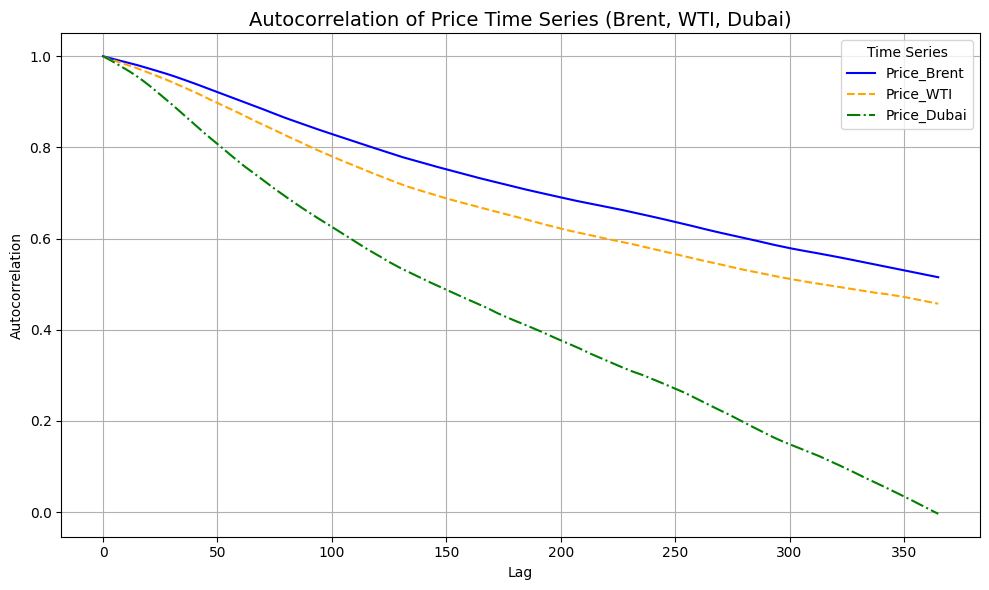

In [3]:
def plot_oil_acf(data_acf):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Colors and line styles for each time series
    colors = ['blue', 'orange', 'green']
    linestyles = ['-', '--', '-.']

    # Plot autocorrelation for each time series
    for idx, colname in enumerate(['Price_Brent', 'Price_WTI', 'Price_Dubai']):
        time_series = data_acf[colname].dropna()
        
        # Compute autocorrelations using ACF
        autocorr = acf(time_series, nlags=365)
        
        # Plot the autocorrelation with a specific color and linestyle
        ax.plot(autocorr, label=colname, color=colors[idx], linestyle=linestyles[idx])

    # Add labels and title
    ax.set_xlabel('Lag')
    ax.set_ylabel('Autocorrelation')
    ax.set_title('Autocorrelation of Price Time Series (Brent, WTI, Dubai)', fontsize=14)
    ax.legend(title='Time Series', loc='upper right')

    # Add grid for better readability
    ax.grid(True)

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

# plot all data
data_acf_all = (
    COMBINED_DATA
    .copy()
)

plot_oil_acf(data_acf_all)



We observe similar ACF plots of the Brent and WTI oil futures, when we decide to plot the autocorrelation of each time series while keeping all the data. However, the Dubai futures plot has a completely different shape. Need to investigate this further, or decide to exclude it from the analysis.

This prompts us to have a look at the raw data again. After investigating further, we found that the data source provides us with WTI and Brent data from 01 Jan 2000, but the Dubai series only starts from 28 April 2018.

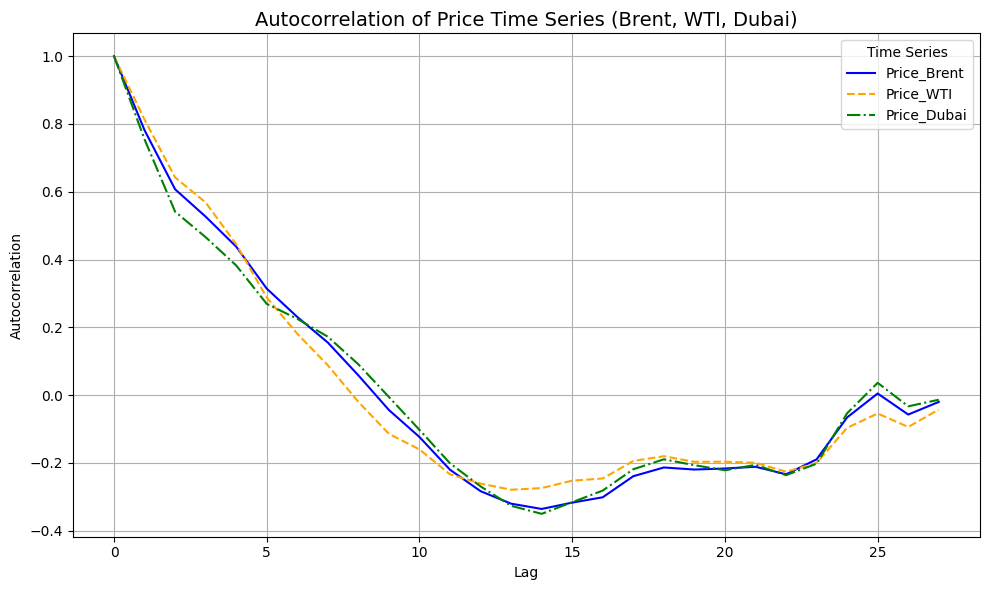

In [4]:
# before plotting all data
# drop all nan cols
data_acf = (
    COMBINED_DATA
    .copy()
    .dropna()
)

plot_oil_acf(data_acf)

If we drop all nan values before plotting, i.e. keeping only data points where all three oil futures are not nan values, we see that the autocorrelation plots are very similar for all three oil futures. This is more of what we would expect to see, as all three are used as benchmarks for 'very similar' commodities.

Interpretation of Autocorrelation Plot:
- Very high (close to 1.0) autocorrelations for lag 1, decreasing towards zero and even negative values at around lag 8.
- Indication of trends or seasonality in the data.
- The decay of the lag suggests non-stationarity in the time series (which is expected for financial price data).
- We do not see repeating peaks or cycles, so seasonality might not be the case.

### Testing for Stationarity
- Stationarity is a fundamental assumption for many time series models, including the well-known ARIMA, GARCH, and VAR. 
- If the series is not stationary, testing for autocorrelation may lead to false conclusions, as trends or seasonality can artificially inflate correlations.
- Non-stationarity: time-varying mean or variance, violating the assumptions of many statistical tools.

We will test for stationarity in the raw price data, and the returns data (even though we expect returns to be already stationarity).

### Augmented Dickey-Fuller (ADF) Test

This test is used to check for the presence of a unit root. A linear stochastic process has a unit roof, if 1 is a root of the process's characteristic equation. When such a unit root is present, the process is non-stationary, but is not neccessarily trending. If the other roots of the characteristic equation are inside the unit circle, i.e. have an absolute value less than one, then the first difference of the process will be stationary. Otherwise the process will need to be differenced multiple times to become stationary: if there are $d$ unit roots, we will need to take $d$ differences to produce a stationary series.

For the ADF test, we assume the following model for the time series $\{ y_t \}^T_{t=0}$:

\begin{equation*}
    \Delta y_t = \alpha + \beta_t + \gamma y_{t-1} + \delta_1 y_{t-1} + \cdots + \delta_{p} y_{t-p} + \epsilon_t
\end{equation*}

Where $\alpha$ is a constant or vertical axis intercept term, $\beta$ is a coefficient for the time trend, $\gamma$ is the coefficient of the lagged level of $y$, $p$ the lag order of the autoregressive process, and $\Delta$ is the single-time-step difference operator.

The test hypotheses are:

\begin{align*}
    H_0: & \: \gamma = 0 \; \text{and} \; \beta = 0
    \\
    H_1: & \: \gamma \lt 0 \; \text{and} \; \beta \neq 0
\end{align*}

i.e. under the null hypothesis of a stochastic trend, the series $y_t$ is integrated of order 1, such that the added regressors $\Delta y_t$ are all stationary. If the null hypothesis is rejected, then we have statistical evidence that the time series is stationary. 

The ADF test statistic has a non-standard distribution, as it is done over the residual term of the regression rather than the raw data.

The intuition for the test is as follows:
- If $y_t$ is stationary (or trend-stationary), then it has a tendency to return to a constant mean.
- Large values will tend to be followed by smaller values (negative changes), and vice versa. 
- Hence, the level of the series will be a significant predictor of the next period's changes, and will have a negative coefficient such that it is inversely correlated to the current change.
- On the other hand, if the series is integrated, then the positive and negative changes occur with probabilities that do not depend on the current level of the series, which is called a stochastic trend.
- The ADF test also removes all the structural effects in the time series (the autocorrelation).


Source:
Heij, Christiaan, and others, Econometric Methods with Applications in Business and Economics (Oxford, 2004; online edn, Oxford Academic, 31 Oct. 2023)

In [5]:

# Define a function to perform the ADF test
def run_adf_test(series, column_name):
    series = series.dropna()
    adf_result = adfuller(series, maxlag=100, autolag='AIC')  # Autolag selects the best lag using AIC
    print(f"Results of ADF Test for {column_name}:")
    print(f'Lag Used: {adf_result[2]}')
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}")
    print("Critical Values:")
    for key, value in adf_result[4].items():
        print(f"   {key}: {value}")
    if adf_result[1] <= 0.05:
        print(f"The null hypothesis is rejected. {column_name} is stationary.\n")
    else:
        print(f"Failed to reject the null hypothesis. {column_name} is non-stationary.\n")



In [6]:
# Apply the function to each price column
columns_to_test = ['Price_WTI', 'Price_Brent', 'Price_Dubai']

for column in columns_to_test:
    run_adf_test(COMBINED_DATA.loc[:,columns_to_test][column], column)

Results of ADF Test for Price_WTI:
Lag Used: 39
ADF Statistic: -2.95351238478095
p-value: 0.039469767446143
Critical Values:
   1%: -3.4313802276274816
   5%: -2.861995270514118
   10%: -2.5670123373798748
The null hypothesis is rejected. Price_WTI is stationary.

Results of ADF Test for Price_Brent:
Lag Used: 32
ADF Statistic: -2.574681359709517
p-value: 0.0983438318740486
Critical Values:
   1%: -3.4313773143767716
   5%: -2.861993983334536
   10%: -2.5670116521846436
Failed to reject the null hypothesis. Price_Brent is non-stationary.

Results of ADF Test for Price_Dubai:
Lag Used: 0
ADF Statistic: -2.1653251285082478
p-value: 0.21907019230407393
Critical Values:
   1%: -3.432807985211508
   5%: -2.8626259540301553
   10%: -2.5673480904338657
Failed to reject the null hypothesis. Price_Dubai is non-stationary.



The ADF test shows stationarity for the Brent and Dubai oil futures, but not for the WTI futures. The Dubai oil futures again show irregularity, with a value of zero for 'Lag Used'. We will try the test again, but after dropping all rows with nan values.

In [7]:
# Apply the function to each price column
columns_to_test = ['Price_WTI', 'Price_Brent', 'Price_Dubai']

for column in columns_to_test:
    run_adf_test(COMBINED_DATA.loc[:,columns_to_test].dropna()[column], column)

Results of ADF Test for Price_WTI:
Lag Used: 3
ADF Statistic: -2.4682616784605598
p-value: 0.12338878643108453
Critical Values:
   1%: -3.432811686398781
   5%: -2.8626275885637775
   10%: -2.5673489606664854
Failed to reject the null hypothesis. Price_WTI is non-stationary.

Results of ADF Test for Price_Brent:
Lag Used: 6
ADF Statistic: -2.4123435455675115
p-value: 0.13828279923331283
Critical Values:
   1%: -3.432814469612307
   5%: -2.862628817696705
   10%: -2.567349615062282
Failed to reject the null hypothesis. Price_Brent is non-stationary.

Results of ADF Test for Price_Dubai:
Lag Used: 0
ADF Statistic: -2.1649511474513803
p-value: 0.2192111139143551
Critical Values:
   1%: -3.4328089094645335
   5%: -2.8626263622027865
   10%: -2.5673483077466708
Failed to reject the null hypothesis. Price_Dubai is non-stationary.



Now, the three time series show similar lag values used for the ADF test. However, note that the ADF tests still have relatively low (near or below 0.2) p-values. Intuitively, we can interpret this as the oil prices being near stationary. This makes sense, as compared to e.g. the US equity indices, commodity prices should not really show an upward trend with respect to time, as unlike companies, commodities do not really 'grow larger'.

We note that we have found another irregularity with the Dubai time series, and we must decide whether to proceed with two options:

1. Remove all pre-2014 data, and run the analysis on all three oil futures
2. Remove the Dubai series and work only with the WTI and Brent futures
3. Try to find more data for the Dubai series, pre-2014 (we are unsure whether this even exists)

We decide to choose the first option, such that we may also used error correction models to observe cointegration relations between the three oil futures.

In [8]:
MODELING_DATA = (
    COMBINED_DATA
    .loc[:,['Change_WTI', 'Change_Brent', 'Change_Dubai']]
    .dropna()
    .reset_index(drop=True)
)

display(MODELING_DATA)

,Change_WTI,Change_Brent,Change_Dubai
0,0.0024,-0.0133,0.0000
1,0.0044,0.0080,0.0000
2,-0.0152,-0.0084,0.0000
3,-0.0032,-0.0029,0.0000
4,0.0034,0.0077,0.0000
...,...,...,...
2658,0.0163,0.0117,0.0032
2659,-0.0323,-0.0217,-0.0064
2660,-0.0025,-0.0027,0.0000
2661,-0.0007,0.0003,0.0000


### ARIMA Models

Now, we fit the simplest ARMA(1,1) with one autoregressive and one moving average term. As we know that the time series of prices are non-stationary from the ADF tests, this motivates us to take differences, and in the case of financial time series we will look at the returns:

\begin{equation*}
    R_t = \frac{y_t - y_{t-1}}{|y_{t-1}|}
\end{equation*}

Note that we have the absolute value term in the denominator, which is needed to handle negativec values. While prices of assets such as equities should be bounded by zero, in 2020, we had the WTI oil futures reach negative values due to extremely weak demand at the delivery date.


Fitting ARIMA model for Change_WTI
                               SARIMAX Results                                
Dep. Variable:             Change_WTI   No. Observations:                 2663
Model:                 ARIMA(1, 0, 1)   Log Likelihood                3442.658
Date:                Tue, 17 Dec 2024   AIC                          -6877.315
Time:                        14:09:06   BIC                          -6853.767
Sample:                             0   HQIC                         -6868.793
                               - 2663                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.004     -0.315      0.753      -0.008       0.006
ar.L1         -0.1171      0.015     -7.839      0.000      -0.146      -0.088
ma.L1          0

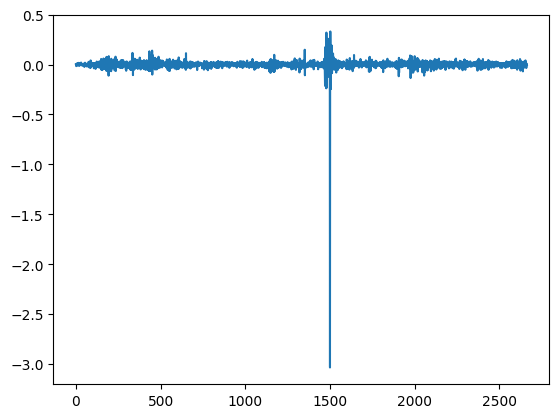


Fitting ARIMA model for Change_Brent
                               SARIMAX Results                                
Dep. Variable:           Change_Brent   No. Observations:                 2663
Model:                 ARIMA(1, 0, 1)   Log Likelihood                6195.918
Date:                Tue, 17 Dec 2024   AIC                         -12383.835
Time:                        14:09:06   BIC                         -12360.286
Sample:                             0   HQIC                        -12375.313
                               - 2663                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.375      0.708      -0.001       0.001
ar.L1         -0.0077      0.918     -0.008      0.993      -1.808       1.793
ma.L1         

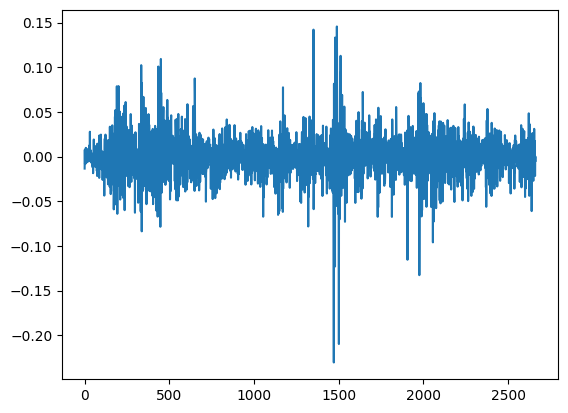


Fitting ARIMA model for Change_Dubai
                               SARIMAX Results                                
Dep. Variable:           Change_Dubai   No. Observations:                 2663
Model:                 ARIMA(1, 0, 1)   Log Likelihood                6445.330
Date:                Tue, 17 Dec 2024   AIC                         -12882.659
Time:                        14:09:06   BIC                         -12859.110
Sample:                             0   HQIC                        -12874.137
                               - 2663                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.857e-05      0.000      0.240      0.810      -0.001       0.001
ar.L1         -0.0441      0.248     -0.178      0.859      -0.530       0.442
ma.L1         

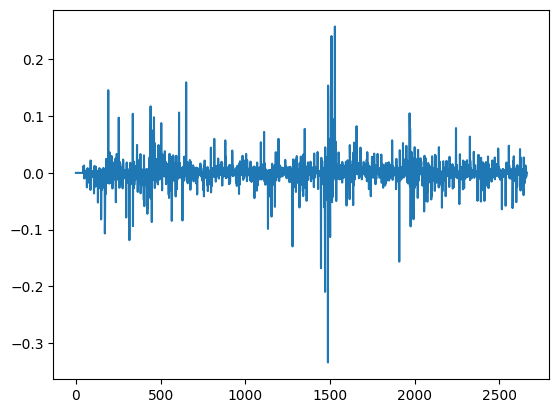

In [9]:
from statsmodels.tsa.arima.model import ARIMA


# Function to check stationarity and fit ARIMA
def fit_arima(series, order=(1, 0, 1)):
    
    # Fit ARIMA model
    model = ARIMA(series, order=order)
    model_fit = model.fit()
    
    return model_fit

# Fitting ARIMA models to each column
models_naieve = {}
for column in ['Change_WTI', 'Change_Brent', 'Change_Dubai']:
    print(f"\nFitting ARIMA model for {column}")

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        model_fit = fit_arima(MODELING_DATA[column])
    print(model_fit.summary())
    model_fit.resid.plot()
    plt.show()
    models_naieve[column] = model_fit


The Statsmodels package summarizes the results of the regression model, and also automatically runs several statistical tests on the time series:

- Coefficents of Lags: Only the model for the WTI oil price produces statistically significant results for the coefficients 1-period lagged AR and 1-period lagged MA terms. The test for significant coefficents used is the standard t-test, as this is what is used for testing statistical significance of individual model coefficients. 
- Significance of Autocorrelations: The Ljung-Box Q statistic is used to test whether a group of autocorrelations of the time series are different from zero. This test is run on the residuals of each fitted ARIMA model, such that the hypothesis being tested is whether the residuals of the model have no autocorrelation. The results for all three models show that none show statistical evidence of residual autocorrelation, which is a good indication that a first difference of the time series is sufficient.
- Heteroskedasticity: An assumption of OLS estimators for linear models is that random errors have the same finite variance, i.e. they are homoskedastic. If this assumption is violated, then the Gauss-Markov theorem does not apply, and the OLS estimator does not have the lowest variance of all other unbiased estimators. However, estimates of model coefficients are still unbiased. The test for homoscedasticity utilizes the Goldfeld-Quandt test. For all three models, we have very low p-values for this test, indicating the assumption of homoskedasticity does not hold. This is as expected for a financial time series, where we have volatility clustering.
- Normality: Another assumption of OLS / 'standard' linear models is that the random errors are normally distributed. For financial time series, we expect to have 'fat tailed' distributions that are not normally distributed. The Jarque-Bera test validates this expectation, as we reject the null hypothesis of normality for the residuals of all three datasets.
- Residuals: from the residual plots, we observe that the WTI futures has much higher variation in the residuals. This was due to the negative price of the futures in 20 April 2020. Negative prices did not happen to the other oil futures.


Now, we attempt to find better specifications of the ARMA models using the Bayesian Information Criterion:

\begin{equation*}
    BIC = - 2 log(\hat{L}) + k \cdot log(n)
\end{equation*}

where $\hat{L}$ is the (maximized) likelihood of the model, $k$ the number ofmodel parameters, and $n$ the number of observed data points. Intuitively, a better-fitting model will have a higher likelihood, therefore lower negative log-likelihood, causing better models to have lower BIC. To penalize model complexity, the term $k \cdot log(n)$ is added.

For each model, we train models with combinations of AR-MA degrees, starting from 1 up to 3. We then report the coefficients and statistical tests of only the models with the lowest BIC.


Fitting ARIMA model for Change_WTI
Current Degree: (AR:1, MA:1)
Current BIC: [-6853.767]
Current Degree: (AR:1, MA:2)
Current BIC: [-6854.902]
Current Degree: (AR:1, MA:3)
Current BIC: [-6854.543]
Current Degree: (AR:2, MA:1)
Current BIC: [-6865.284]
Current Degree: (AR:2, MA:2)
Current BIC: [-6859.166]
Current Degree: (AR:2, MA:3)
Current BIC: [-6867.914]
Current Degree: (AR:3, MA:1)
Current BIC: [-6862.468]
Current Degree: (AR:3, MA:2)
Current BIC: [-6762.835]
Current Degree: (AR:3, MA:3)
Current BIC: [-6858.477]
                               SARIMAX Results                                
Dep. Variable:             Change_WTI   No. Observations:                 2663
Model:                 ARIMA(2, 0, 3)   Log Likelihood                3461.562
Date:                Tue, 17 Dec 2024   AIC                          -6909.124
Time:                        14:09:15   BIC                          -6867.914
Sample:                             0   HQIC                         -6894.211
    

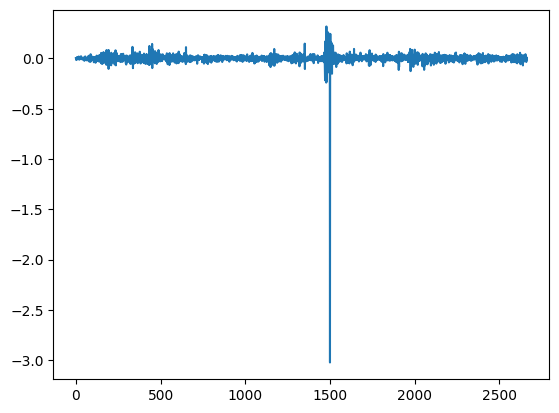


Fitting ARIMA model for Change_Brent
Current Degree: (AR:1, MA:1)
Current BIC: [-12360.286]
Current Degree: (AR:1, MA:2)
Current BIC: [-12355.860]
Current Degree: (AR:1, MA:3)
Current BIC: [-12349.879]
Current Degree: (AR:2, MA:1)
Current BIC: [-12353.826]
Current Degree: (AR:2, MA:2)
Current BIC: [-12345.878]
Current Degree: (AR:2, MA:3)
Current BIC: [-12342.904]
Current Degree: (AR:3, MA:1)
Current BIC: [-12349.300]
Current Degree: (AR:3, MA:2)
Current BIC: [-12341.153]
Current Degree: (AR:3, MA:3)
Current BIC: [-12334.318]
                               SARIMAX Results                                
Dep. Variable:           Change_Brent   No. Observations:                 2663
Model:                 ARIMA(1, 0, 1)   Log Likelihood                6195.918
Date:                Tue, 17 Dec 2024   AIC                         -12383.835
Time:                        14:09:20   BIC                         -12360.286
Sample:                             0   HQIC                        -123

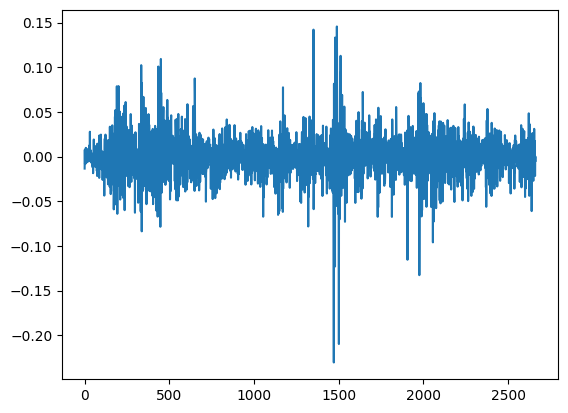


Fitting ARIMA model for Change_Dubai
Current Degree: (AR:1, MA:1)
Current BIC: [-12859.110]
Current Degree: (AR:1, MA:2)
Current BIC: [-12867.051]
Current Degree: (AR:1, MA:3)
Current BIC: [-12858.554]
Current Degree: (AR:2, MA:1)
Current BIC: [-12851.257]
Current Degree: (AR:2, MA:2)
Current BIC: [-12854.260]
Current Degree: (AR:2, MA:3)
Current BIC: [-12849.741]
Current Degree: (AR:3, MA:1)
Current BIC: [-12845.725]
Current Degree: (AR:3, MA:2)
Current BIC: [-12837.833]
Current Degree: (AR:3, MA:3)
Current BIC: [-12829.979]
                               SARIMAX Results                                
Dep. Variable:           Change_Dubai   No. Observations:                 2663
Model:                 ARIMA(1, 0, 2)   Log Likelihood                6453.243
Date:                Tue, 17 Dec 2024   AIC                         -12896.487
Time:                        14:09:27   BIC                         -12867.051
Sample:                             0   HQIC                        -128

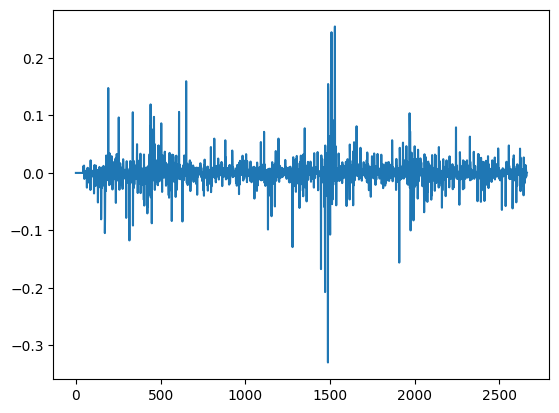

In [10]:

def fit_arima_bic(series, max_degree=3):
    best_bic = np.inf
    best_model = None


    for degree_ar in range(1, max_degree + 1):
        for degree_ma in range(1, max_degree + 1):
            print(f'Current Degree: (AR:{degree_ar}, MA:{degree_ma})')
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                current_model = fit_arima(series, order=(degree_ar, 0, degree_ma))
            print(f'Current BIC: [{current_model.bic:.3f}]')
            if current_model.bic < best_bic:
                best_bic = current_model.bic
                best_model = current_model

    return best_model


# Fitting ARIMA models to each column
models_bic = {}
for column in ['Change_WTI', 'Change_Brent', 'Change_Dubai']:
    print(f"\nFitting ARIMA model for {column}")
    model_fit = fit_arima_bic(MODELING_DATA[column])
    print(model_fit.summary())
    model_fit.resid.plot()
    plt.show()
    models_bic[column] = model_fit

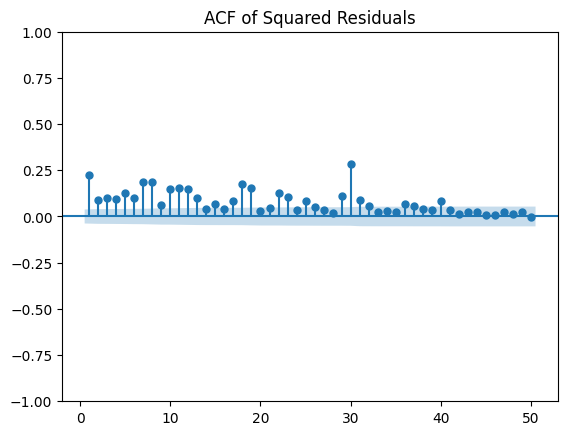

In [43]:
from statsmodels.graphics.tsaplots import plot_acf

# Compute squared residuals
squared_residuals = models_bic['Change_Brent'].resid ** 2

# Plot ACF of squared residuals
plot_acf(
    squared_residuals,
    alpha=0.05,
    lags=50, 
    title="ACF of Squared Residuals", 
    zero=False,
)
plt.show()


We also plot the autocorrelations of the squared residuals, to see whether there is volatility clustering:

Change_WTI


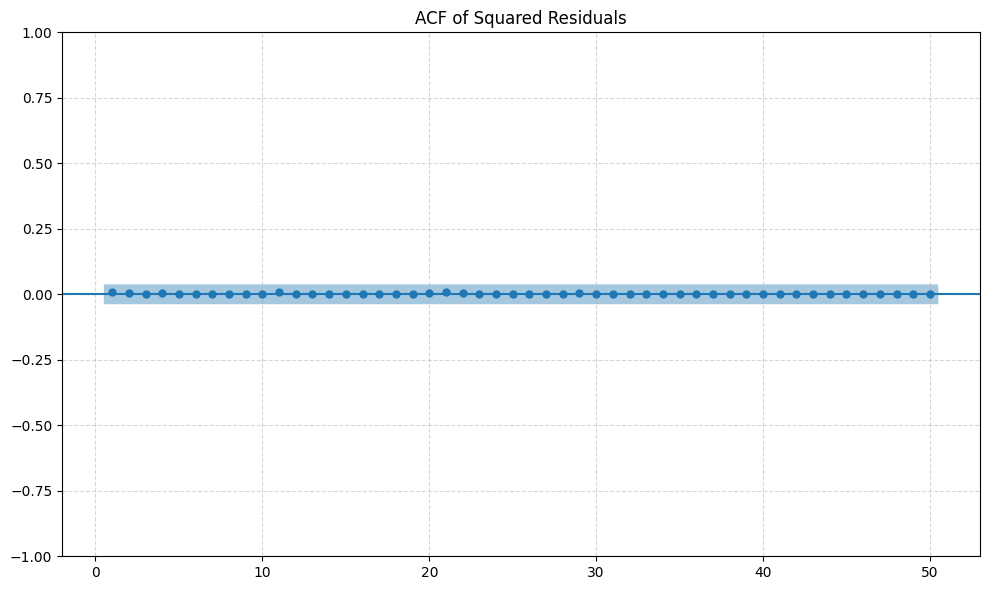

Change_Brent


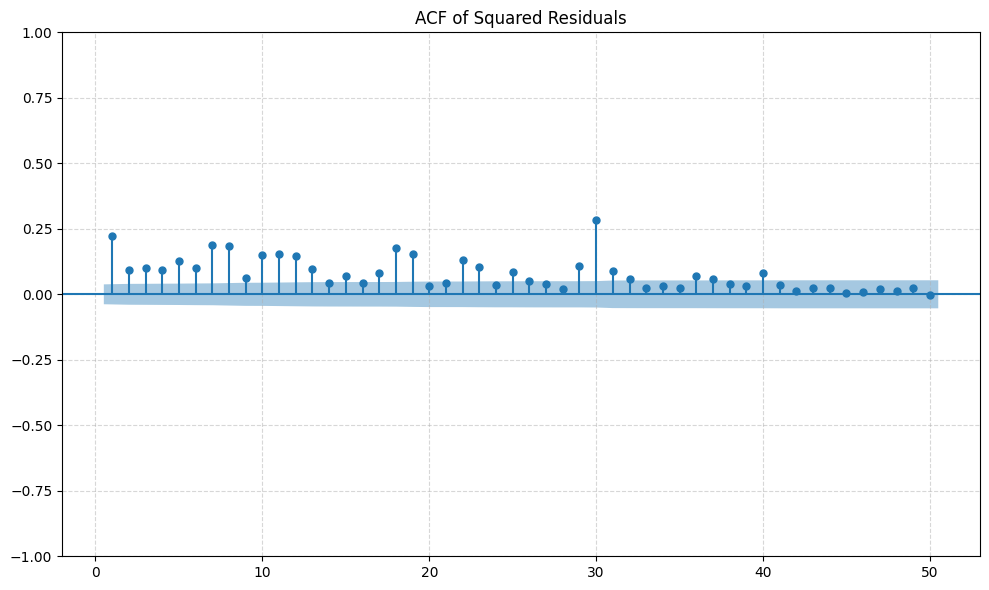

Change_Dubai


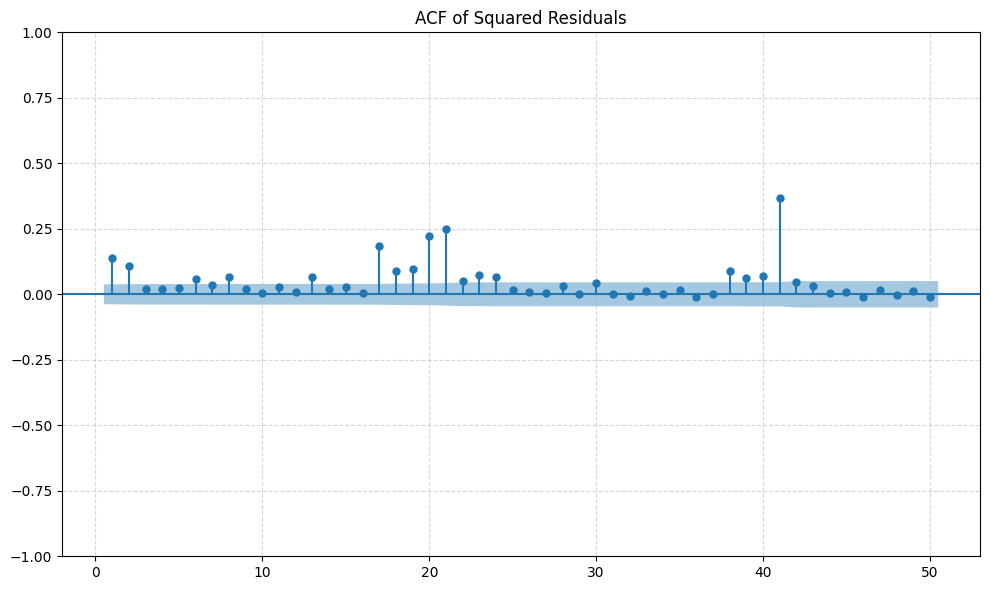

In [53]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Compute squared residuals
for model_name, model_fit in models_bic.items():
    print(model_name)
    squared_residuals = model_fit.resid ** 2

    # Create the ACF plot
    fig, ax = plt.subplots(figsize=(10, 6))  # Custom figure size

    plot_acf(
        squared_residuals,
        alpha=0.05,            # Confidence level
        lags=50,               # Number of lags
        title="ACF of Squared Residuals", 
        zero=False,
        ax=ax
    )

    # Customize the grid
    ax.grid(True, linestyle="--", alpha=0.5)  # Add dashed gridlines with transparency

    # Adjust confidence region shading
    for polygon in ax.collections[1:]:  # Confidence intervals are drawn as collections
        polygon.set_alpha(0.4)          # Make confidence region more shaded

    plt.tight_layout()
    plt.show()


Comparing the models chosen based on BIC and the simplest ARMA(1,1) models:

- The model parameters for WTI and Dubai futures change, while the 'best' model for the Brent futures remains the same.
- The Ljung-Box tests for residual autocorrelation, Goldfeld-Quandt tests for heteroskedasticity, and Jarque-Bera tests for normality do not change their conclusions.
- It is interesting to note that the models for WTI and Dubai now have statistically significant coefficients of their autoregressive and moving average terms.

Possible interpretations for the Brent futures:
- Driving Factors: Brent prices may be influenced by less predictable factors, such as greater exposure to geopolitical events, diversity of market participants or hedging activities that produce noise, or lower persistence in price movements reducing predictive power of past values or errors.
- White Noise: If returns for Brent may be closer to being white noise, i.e. fully random, the ARIMA model will have difficulty identifying significant patterns, causing non-significant model coefficients.
- Volatility Patterns: The Jarque-Bera test for normality has the least extreme values for the 